In [11]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

In [12]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)
df_small = df[::100].reset_index(drop=True)

In [4]:
dayname = {0:'월', 1:'화', 2:'수', 3:'목',4: '금',5: '토',6: '일'}

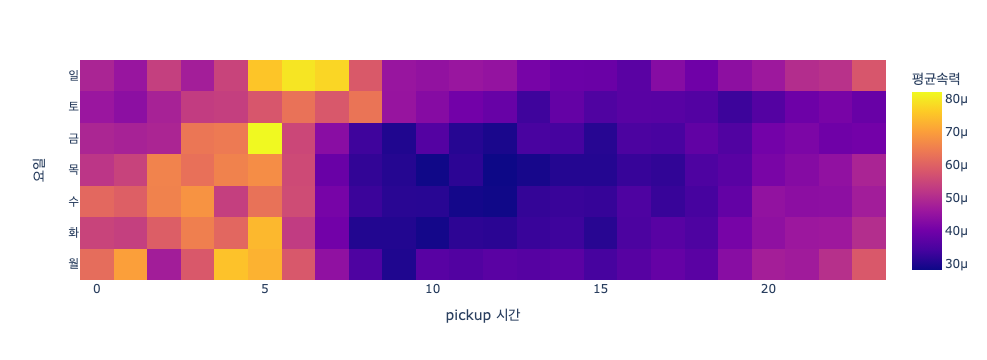

In [6]:
tidy=df.pivot_table(index=['dayofweek', 'pickup_hour'], values='speed', aggfunc='mean')\
.rename({'speed':'speed_mean'},axis=1).reset_index()\
.assign(요일= lambda df : df['dayofweek'].map(dayname))
tidy

fig = px.density_heatmap(
    data_frame=tidy,
    x='pickup_hour',
    y='요일',
    z='speed_mean',
    nbinsx=24,
    nbinsy=7
)
fig.update_layout(
    xaxis={'title':'pickup 시간'},
    coloraxis_colorbar_title_text = '평균속력'
)

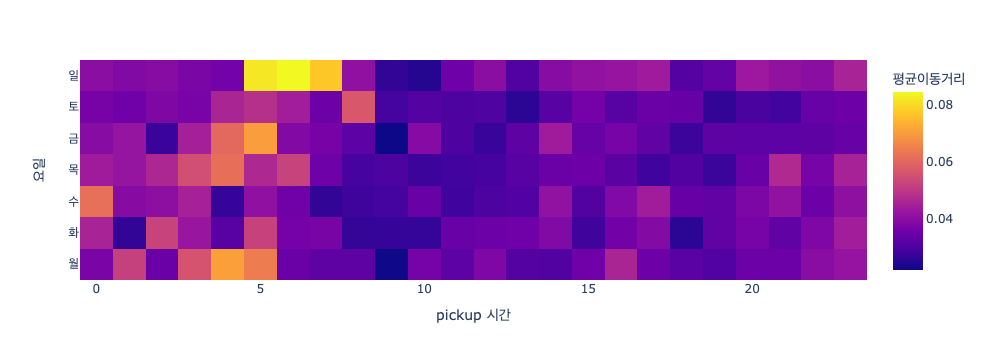

In [8]:
tidy=df.pivot_table(index=['dayofweek', 'pickup_hour'], values='dist', aggfunc='mean')\
.rename({'dist':'dist_mean'},axis=1).reset_index()\
.assign(요일= lambda df : df['dayofweek'].map(dayname))
tidy

fig = px.density_heatmap(
    data_frame=tidy,
    x='pickup_hour',
    y='요일',
    z='dist_mean',
    nbinsx=24,
    nbinsy=7
)
fig.update_layout(
    xaxis={'title':'pickup 시간'},
    coloraxis_colorbar_title_text = '평균이동거리'
)

In [9]:
pcol = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'pickup_hour']
dcol = ['dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_hour']
def transform(df):
    pickup = df.loc[:,['id']+pcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'pickup')
    dropoff = df.loc[:,['id']+dcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'dropoff')
    return pd.concat([pickup,dropoff],axis=0)
df_left = df_small.drop(pcol+dcol,axis=1)
df_right = pd.concat([transform(df) for i, df in df_small.groupby('id')]).reset_index(drop=True)
df_feature_small2 = df_left.merge(df_right)
df_feature_small2.head()

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,dayofweek,datetime,longitude,latitude,hour,type
0,id2875421,B,1,N,455,6.120297,0.017680,0.000039,0,2016-03-14 17:24:55,-73.982155,40.767937,17,pickup
1,id2875421,B,1,N,455,6.120297,0.017680,0.000039,0,2016-03-14 17:32:30,-73.964630,40.765602,17,dropoff
2,id3667993,B,1,N,486,6.186209,0.023482,0.000048,6,2016-01-03 04:18:57,-73.980522,40.730530,4,pickup
3,id3667993,B,1,N,486,6.186209,0.023482,0.000048,6,2016-01-03 04:27:03,-73.997993,40.746220,4,dropoff
4,id2002463,B,1,N,501,6.216606,0.012256,0.000024,3,2016-01-14 12:28:56,-73.965652,40.768398,12,pickup


/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



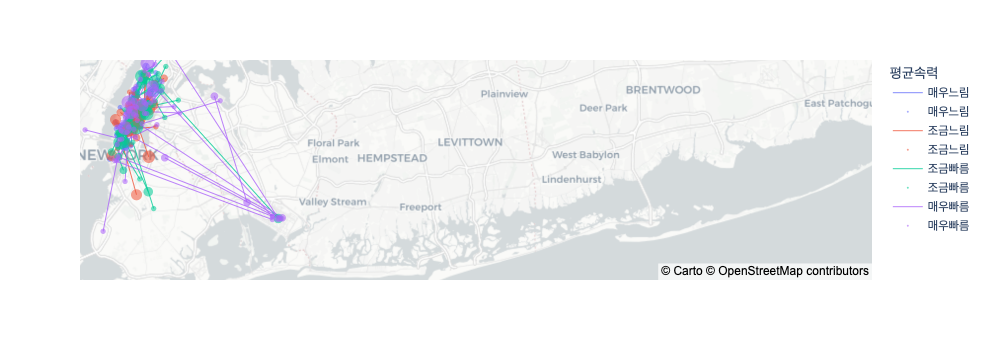

In [10]:
tidydata = df_feature_small2.assign(
    speed_cut = pd.qcut(df_feature_small2.speed,4,labels=['매우느림','조금느림','조금빠름','매우빠름'])
).sort_values('speed_cut')
fig = px.line_mapbox(
    data_frame=tidydata,
    lat = 'latitude',
    lon = 'longitude',
    line_group = 'id',
    color = 'speed_cut',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=11 
)
scatter_data = px.scatter_mapbox(
    data_frame=tidydata,
    lat = 'latitude',
    lon = 'longitude',
    size = 'passenger_count',
    size_max = 10,
    color = 'speed_cut',
    #---#
    mapbox_style = 'carto-positron',
    zoom=11
).data 
for sd in scatter_data: 
    fig.add_trace(sd)
fig.update_traces(
    line={
        'width':1
    },
    opacity=0.8,
)
fig.update_legends({'title':'평균속력'})

for i in range(len(fig.data)):
  if fig.data[i].mode == 'markers':
    fig.data[i].name += ' (pickup/dropoff)'
  else:
    fig.data[i].name += ' (path)'
      
fig.show()